# In this notebook we fit an ensemble SEIR model with hidden states to the Russia Covid-19 data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm
from copy import deepcopy
from scipy.special import softmax
from sklearn.metrics import mean_absolute_error
from scipy.stats import iqr
import joblib

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [27]:
from sir_models.models import SEIRHidden
from sir_models.fitters import HiddenCurveFitter
from sir_models.ensemble import EnsembleModel
from sir_models.utils import stepwise, eval_on_select_dates_and_k_days_ahead

# Load data

In [8]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
df = pd.read_csv(DATASET_PATH)

In [9]:

useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)
df.date = pd.to_datetime(df.date)

df = df[df.location == 'Russia']

df['total_deaths'] = df.total_deaths.fillna(0)
df['new_deaths'] = df.new_deaths.fillna(0)
df.head().T

,52406,52407,52408,52409,52410
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00
total_cases,2.0,2.0,2.0,2.0,2.0
new_cases,2.0,0.0,0.0,0.0,0.0
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,0.0,0.0,0.0,0.0,0.0
new_deaths,0.0,0.0,0.0,0.0,0.0
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN
reproduction_rate,NaN,NaN,NaN,NaN,NaN
new_tests,NaN,NaN,NaN,NaN,NaN


In [10]:
df = df.fillna(0)

# Define model and fitter

In [16]:
class SEIRHidden_OWID(SEIRHidden):
    def get_fit_params(self, data):
        params = super().get_fit_params(data)
        params['population'].value = df.iloc[0].population
        return params


# Model

In [17]:
train_subset = df[
                #(df.date >= '2020-03-25') & 
                  (df.date <= '2020-11-30')]
train_subset.head()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
52406,Russia,2020-01-31,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52407,Russia,2020-02-01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52408,Russia,2020-02-02,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52409,Russia,2020-02-03,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0
52410,Russia,2020-02-04,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,145934460.0


In [18]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

52711   2020-12-01
52712   2020-12-02
52713   2020-12-03
Name: date, dtype: datetime64[ns]

In [19]:
stepwize_size = 60
model = SEIRHidden_OWID(stepwise_size=stepwize_size)
fitter = HiddenCurveFitter(
     new_deaths_col='new_deaths_smoothed',
     new_cases_col='new_cases_smoothed',
     save_params_every=10
)

ensemble = EnsembleModel.train(model, fitter, train_subset)

KeyboardInterrupt: 

In [ ]:
joblib.dump(ensemble, 'ensemble_russia.pkl')

In [ ]:
result = ensemble.fitter.result
result

In [ ]:
aggregate_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(train_subset)

In [ ]:
(S, E, I, Iv, R, Rv, D, Dv) = aggregate_states
(new_exposed,
         new_infected_invisible, new_infected_visible,
         new_recovered_invisible,
         new_recovered_visible,
         new_dead_invisible, new_dead_visible) = aggregate_daily 

In [ ]:
train_t = np.arange(len(train_subset))

In [ ]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.plot(np.arange(len(train_subset.reproduction_rate)), train_subset.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, Dv, label='predicted visible', color='black')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
print("Coefficient of death underreporting:", (D/Dv).mean().round(3))

In [ ]:
mean_states = np.mean(model_states, axis=0)
iqr_states = iqr(model_states, axis=0)

mean_D = mean_states[-2]
mean_Dv = mean_states[-1]

iqr_D = iqr_states[-2]
iqr_Dv = iqr_states[-1]

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, mean_D, label='predicted invisible', color='black', linestyle='dashed' )
plt.plot(train_subset.date, mean_Dv, label='predicted visible', color='black')

plt.fill_between(train_subset.date, (mean_Dv-iqr_Dv/2), (mean_Dv+iqr_Dv/2), color='black', label='predicted visible ci', alpha=.1)
plt.fill_between(train_subset.date, (mean_D-iqr_D/2), (mean_D+iqr_D/2), color='grey', label='predicted invisible ci', alpha=.1)

plt.legend()
plt.title('Total deaths mean ensemble')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')

plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')

plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')
plt.legend()
plt.title('Daily deaths')
plt.show()

In [ ]:
mean_daily_vals = np.mean(model_daily_vals, axis=0)
std_daily_vals = np.std(model_daily_vals, axis=0)

mean_daily_dead_visible = mean_daily_vals[-1]
mean_daily_dead_invisible = mean_daily_vals[-2]

std_daily_dead_visible = std_daily_vals[-1]
std_daily_dead_invisible = std_daily_vals[-2]

plt.figure(figsize=(10, 7))
plt.plot(train_subset.date[:-1], mean_daily_dead_visible, label='daily deaths_visible', color='black')
plt.plot(train_subset.date[:-1], mean_daily_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')

plt.fill_between(train_subset.date[:-1], (mean_daily_dead_visible-std_daily_dead_visible), (mean_daily_dead_visible+std_daily_dead_visible), color='black', label='predicted visible ci', alpha=.1)
plt.fill_between(train_subset.date[:-1], (mean_daily_dead_invisible-std_daily_dead_invisible), (mean_daily_dead_invisible+std_daily_dead_invisible), color='grey', label='predicted invisible ci', alpha=.1)

plt.legend()
plt.title('Daily deaths mean ensemble')
plt.show()


In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted invisible', color='red', linestyle='dashed' )
plt.plot(train_subset.date, Iv.cumsum(), label='predicted visible', color='red')
plt.legend()
plt.title('Total infections')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='ground truth')

plt.plot(train_subset.date[:-1], new_infected_visible, label='daily infected_visible', color='red')

plt.plot(train_subset.date[:-1], new_infected_invisible, label='daily infected_invisible', color='red', linestyle='dashed')
plt.legend()
plt.title('Daily infections')
plt.show()

# Obtain forecast

In [ ]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [ ]:
train_t[-5:], test_t[:5]

In [ ]:
test_initial_conds = (S[-1], E[-1], I[-1], Iv[-1], R[-1], Rv[-1], D[-1], Dv[-1])

In [ ]:
test_aggregate_states, test_aggregate_daily, test_model_states, test_model_daily_vals, test_history = ensemble.predict(t=test_t, 
                                                                                                initial_conditions=test_initial_conds)

(test_S, test_E, test_I, test_Iv, test_R, test_Rv, test_D, test_Dv) = test_aggregate_states

(test_new_exposed,
         test_new_infected_invisible, test_new_infected_visible,
         test_new_recovered_invisible,
         test_new_recovered_visible,
         test_new_dead_invisible, test_new_dead_visible) = test_aggregate_daily

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='train ground truth')
# plt.plot(train_subset.date, D, label='train fit invisible')

plt.plot(test_subset.date, test_subset['total_deaths'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, test_Dv, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
# plt.plot(train_subset.date[:-1], new_dead_visible, label='daily deaths_visible', color='black')
# plt.plot(train_subset.date[:-1], new_dead_invisible, label='daily deaths_invisible', color='black', linestyle='dashed')
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_deaths_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_dead_invisible, label='test forecasted invisible', color='black', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_dead_visible, label='test forecasted visible', color='black', linestyle=':')
plt.legend()
plt.title('Daily deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='train ground truth')
# plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_cases'], label='test ground truth', color='red')
# plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date, Iv.sum()+test_Iv.cumsum(), label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Total Infected')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases_smoothed'], label='train ground truth')

plt.plot(test_subset.date, test_subset['new_cases_smoothed'], label='test ground truth', color='blue')
plt.plot(test_subset.date[:-1], test_new_infected_invisible, label='test forecasted invisible', color='red', linestyle='dashed')
plt.plot(test_subset.date[:-1], test_new_infected_visible, label='test forecasted visible', color='red', linestyle=':')
plt.legend()
plt.title('Daily infections')
plt.show()

# Eval 30 days ahead on fixed dates

In [28]:
K = 30

In [29]:
# Regions where Rt does not jump much
eval_dates = pd.date_range(start='2020-06-01', end='2020-09-01')[::3]
eval_dates[:10], len(eval_dates)

(DatetimeIndex(['2020-06-01', '2020-06-04', '2020-06-07', '2020-06-10',
                '2020-06-13', '2020-06-16', '2020-06-19', '2020-06-22',
                '2020-06-25', '2020-06-28'],
               dtype='datetime64[ns]', freq='3D'),
 31)

In [30]:
def eval_ensemble_owid(train_df, t, train_t, eval_t):
    model = SEIRHidden_OWID()
    fitter = HiddenCurveFitter(
         new_deaths_col='new_deaths_smoothed',
         new_cases_col='new_cases_smoothed',
         max_iters=1000,
         save_params_every=10
    )
    ensemble = EnsembleModel.train(model, fitter, train_df)

    aggregate_states, _, _, _, _ = ensemble.predict(train_df, 
                                                                                                  t=train_t,
                                                                                                  history=False)

    test_initial_conds = [compartment[-1] for compartment in aggregate_states]

    test_states, aggregate_daily, model_states, model_daily_vals, history = ensemble.predict(t=eval_t, 
                                                                                             initial_conditions=test_initial_conds, 
                                                                                             history=False)
    return ensemble, fitter, test_states

In [31]:
models, fitters, model_predictions, train_dfs, test_dfs = eval_on_select_dates_and_k_days_ahead(df,
                                                                                     eval_func=eval_ensemble_owid, 
                                                                                     eval_dates=eval_dates, 
                                                                                     k=K)

Reached max iters
Reached max iters



Reached max iters
Reached max iters



Reached max iters
Reached max iters



Reached max iters
Reached max iters



Reached max iters
Reached max iters



In [34]:
x_dates = [tdf.date.iloc[-1] for tdf in test_dfs]

In [37]:
model_pred_D = [pred[7] for pred in model_predictions]
true_D = [tdf.total_deaths.values for tdf in test_dfs]
baseline_pred_D = [[tdf.iloc[-1].total_deaths]*K for tdf in train_dfs]

In [38]:
overall_errors_model = [mean_absolute_error(true, pred) for true, pred in zip(true_D, model_pred_D)]
overall_errors_baseline = [mean_absolute_error(true, pred) for true, pred in zip(true_D, baseline_pred_D)]

point_errors_model = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, model_pred_D)]
point_errors_baseline = [mean_absolute_error(true[-1:], pred[-1:]) for true, pred in zip(true_D, baseline_pred_D)]

In [39]:
print('Mean overall error baseline', np.mean(overall_errors_baseline).round(3))
print('Mean overall error model', np.mean(overall_errors_model).round(3))

print('Mean point error baseline', np.mean(point_errors_baseline).round(3))
print('Mean point error model', np.mean(point_errors_model).round(3))

Mean overall error baseline 2012.263
Mean overall error model 1191.925
Mean point error baseline 3826.129
Mean point error model 1071.057


### Take a look on one prediction

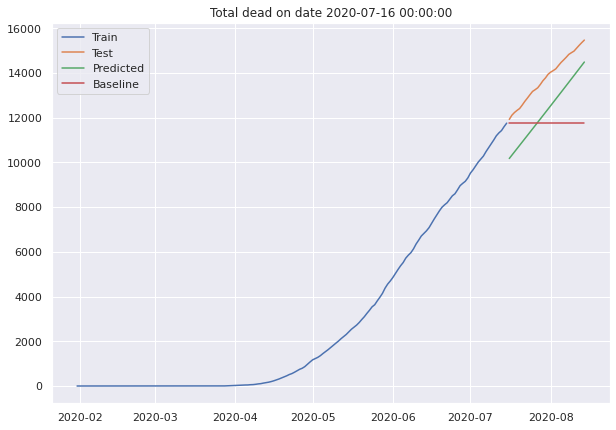

In [41]:
train_df = train_dfs[15]
test_df = test_dfs[15]
model_preds = model_predictions[15]
baseline_predictions = baseline_pred_D[15]
fitter = fitters[15]
plt.figure(figsize=(10, 7))
plt.plot(train_df.date, train_df.total_deaths, label='Train')
plt.plot(test_df.date, test_df.total_deaths, label='Test')
plt.plot(test_df.date, model_preds[7], label='Predicted')
plt.plot(test_df.date, baseline_predictions, label='Baseline')
plt.legend()
plt.title(f'Total dead on date {test_df.date.iloc[0]}')
plt.show()

In [42]:
fitter.result

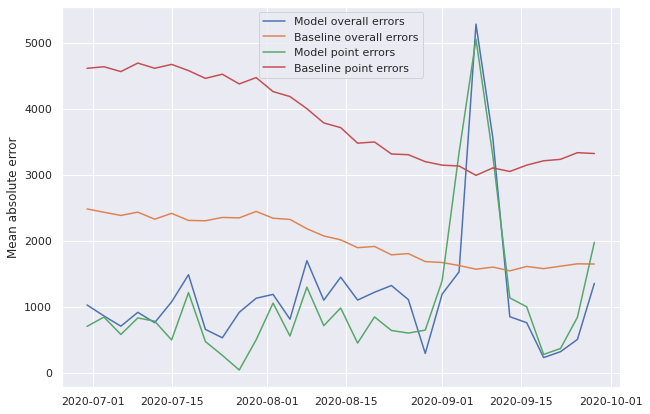

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(x_dates, overall_errors_model, label='Model overall errors')
plt.plot(x_dates, overall_errors_baseline, label='Baseline overall errors')

plt.plot(x_dates, point_errors_model, label='Model point errors')
plt.plot(x_dates, point_errors_baseline, label='Baseline point errors')

plt.legend()
plt.ylabel('Mean absolute error')
plt.show()

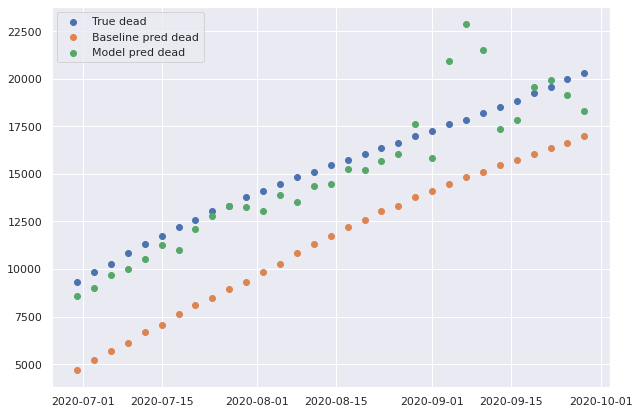

In [44]:
plt.figure(figsize=(10, 7))
plt.scatter(x_dates, [v[-1] for v in true_D], label='True dead')
plt.scatter(x_dates, [v[-1] for v in baseline_pred_D], label='Baseline pred dead')
plt.scatter(x_dates, [v[-1] for v in model_pred_D], label='Model pred dead')

plt.legend()
plt.show()